In [36]:
import cv2
import time
import inspect

import matplotlib.pyplot as plt

from src.cv.core.conv import conv_2d, im2col
from src.cv.core.kernel import Kernel

from scipy.ndimage import convolve

## Convolution operation

### Main idea

Convolution operation is, basically, a weighted sum of the local neighborhood weighted by the matrix called **convolution kernel** or, simply, **kernel**.

Let's imagine that we have $3\times3$ image $X$ of the following form:

$$X = \begin{bmatrix}
x_{00} & x_{01} & x_{02}\\
x_{10} & x_{11} & x_{12}\\
x_{20} & x_{21} & x_{22}\\
\end{bmatrix}$$

If kernel is defined as 

$$K = \begin{bmatrix}
a & b\\
c & d\\
\end{bmatrix}$$

Then convolution of $X$ using $K$ is given by 

$$X' = K * X = \begin{bmatrix}
x'_{00} & x'_{01} \\
x'_{10} & x'_{11} \\
\end{bmatrix}$$

where

$$x'_{00} = (d \cdot x_{00}) + (c \cdot x_{01}) + (b \cdot x_{10}) + (a \cdot x_{11})$$
$$x'_{01} = (d \cdot x_{01}) + (c \cdot x_{02}) + (b \cdot x_{11}) + (a \cdot x_{12})$$
$$x'_{10} = (d \cdot x_{10}) + (c \cdot x_{11}) + (b \cdot x_{20}) + (a \cdot x_{21})$$
$$x'_{11} = (d \cdot x_{11}) + (c \cdot x_{12}) + (b \cdot x_{21}) + (a \cdot x_{22})$$

Elements of the kernel matrix are used as a weighting coefficiens during the calculation of the resulting matrix. 

Note, that they are applied in the reverse order. If we decided to use a direct ordering ($a$, $b$, $c$, $d$), we would calculate cross-correlation instead of convolution.

[source](https://en.wikipedia.org/wiki/Kernel_(image_processing))

### Cross-correlation vs Convolution

Cross-correlation and convolution operators are very similar except one specific property. 

If cross-correlation is being calculated for image with unit signal

$$X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$$

using some kernel 

$$K = \begin{bmatrix}
a & b & c\\
d & e & f\\
g & h & i\\
\end{bmatrix}$$

Then, it would yield a result that repeats a kernel, rotated by $180$ degrees:

$$K \circ X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & i & h & g & 0 \\
0 & f & e & d & 0 \\
0 & c & b & a & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$$

At the same time, convolution operation would produce a resulting image with original ordering of elements in the kernel

$$K * X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & a & b & c & 0 \\
0 & d & e & f & 0 \\
0 & g & h & ai & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$$

For a symmetric kernel, it doesn't matter which operation is used. But for non-symmetric ones, cross-correlation can produce unexpected artifacts. That is the main reason why convolution is an operation of choice in many computer vision algorithms.

[source](https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5#:~:text=Cross%2DCorrelation%3A,of%20displacement%20of%20the%20filter.)

### Application

Convolution with known kernel can be used to perform image blurring, sharpening, embossing, edge detection, etc.

Convolution with unknown kernel is extensively used in CNNs (convolutional neural networks), where the main task is to learn convlutional kernels that extract important visual features from the input images to perform some prediction task.

### Implementation

We would **not** start with naive implementation of convolution operation, because it is extremely inefficient.
Instead, we would discuss how this operation can be perfored as a matrix multiplication.

Let's take closer look on the following equations:

$$x'_{00} = (d \cdot x_{00}) + (c \cdot x_{01}) + (b \cdot x_{10}) + (a \cdot x_{11})$$
$$x'_{01} = (d \cdot x_{01}) + (c \cdot x_{02}) + (b \cdot x_{11}) + (a \cdot x_{12})$$
$$x'_{10} = (d \cdot x_{10}) + (c \cdot x_{11}) + (b \cdot x_{20}) + (a \cdot x_{21})$$
$$x'_{11} = (d \cdot x_{11}) + (c \cdot x_{12}) + (b \cdot x_{21}) + (a \cdot x_{22})$$

It is clear, that we can write them in a form of matrix multiplication:

$$
\begin{bmatrix}
x'_{00} \\
x'_{01} \\
x'_{10} \\
x'_{11} \\
\end{bmatrix}
= 
\begin{bmatrix}
d & c & b & a 
\end{bmatrix} 
\cdot 
\begin{bmatrix}
x_{00} & x_{01} & x_{10} & x_{11}\\
x_{01} & x_{02} & x_{11} & x_{12}\\
x_{10} & x_{11} & x_{20} & x_{21}\\
x_{11} & x_{12} & x_{21} & x_{22}\\
\end{bmatrix}
$$

where second matrix $M$ in the product consists of the all possible patches in the input image to which given kernel is applied. 

In our case, kernel is applied to 4 patches:

$$
\begin{bmatrix}
x_{00} & x_{01} \\
x_{10} & x_{11} \\
\end{bmatrix},
\begin{bmatrix}
x_{01} & x_{02} \\
x_{11} & x_{12} \\
\end{bmatrix},
\begin{bmatrix}
x_{10} & x_{11} \\
x_{20} & x_{21} \\
\end{bmatrix},
\begin{bmatrix}
x_{11} & x_{12} \\
x_{21} & x_{22} \\
\end{bmatrix},
$$

Row-wise traversal of each patch corresponds to column in matrix $M$

This transformation of an image into specific matrix for fast convolution is called **im2col** algorithm

In [30]:
print(inspect.getsource(im2col))

def im2col(img: np.ndarray, kernel_size: int, stride: int) -> np.ndarray:
    """
    Transforms image to rectangular representation
    for efficient convolution operation

    :param img:          np.ndarray with shape (h, w, c)
    :param kernel_size:  kernel size
    :param stride:       convolution stride (step)
    :return: np.ndarray with shape (kernel_size * kernel_size) x (out_h * out_w * n_channels)
    """
    channel_rows = []

    img_h, img_w, img_c = img.shape

    for c in range(img_c):
        rows = []
        for i in range(0, img_h - kernel_size + 1, stride):
            for j in range(0, img_w - kernel_size + 1, stride):
                window = img[i: i + kernel_size, j: j + kernel_size, c]
                rows.append(window.flatten())
        channel_rows.append(np.transpose(np.array(rows)))

    return np.hstack(channel_rows)



#### im2col step-by-step:

Iterate through each channel:

    for c in range(img_c):
    
For each channel, create a list to keep patches in vector form:

        rows = []
    
Iterate throgh each possible patch (stride is basically a step):

        for i in range(0, img_h - kernel_size + 1, stride):
                for j in range(0, img_w - kernel_size + 1, stride):
                
Extract patch for $i$-th row and $j$-th column

                    window = img[i: i + kernel_size, j: j + kernel_size, c]
                    
Transform it to vector and append to our list:

                    rows.append(window.flatten())
                    
Transpose and append to list of channel-specific matrices
                    
        channel_rows.append(np.transpose(np.array(rows)))
        
Concatenate channel-specific matrices along $x$-axis

    return np.hstack(channel_rows)

**Note:** For images with more than 1 channel, we are doing a horizontal concatenation of constructed matrices along $x$ axis

As soon as we got **im2col** implemented, the rest of the implementation is trivial:

In [31]:
print(inspect.getsource(conv_2d))

def conv_2d(img: np.ndarray, kernel: np.ndarray, padding: int = 0, stride: int = 1) -> np.ndarray:
    """
    performs 2D convolution operation over image using kernel

    :param img:         np.ndarray with shape (img_h x img_w X n_channels) or (img_h x img_w)
    :param kernel:      np.ndarray with shape (kernel_size x kernel_size)
    :param padding:     constant '0' padding width
    :param stride:      convolution stride (step)
    :return:
    """
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)

    in_h, in_w, channels = img.shape
    kernel_size = kernel.shape[0]

    # add 0's constant padding
    img = pad_img(img, padding)

    out_w = (in_w - kernel_size + 2 * padding) // stride + 1
    out_h = (in_h - kernel_size + 2 * padding) // stride + 1

    M = im2col(img, kernel_size, stride)
    # transform kernel into vector
    K = np.flip(kernel.flatten())
    P = K @ M

    res = P.reshape((out_h, out_w, channels)).astype(np.uint8)

    return res



#### conv2d step-by-step:

Add number of channels as 1 when it is a grayscale image ((h, w) -> (h, w, 1)):

    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)

Save useful dimensions

    in_h, in_w, channels = img.shape
    kernel_size = kernel.shape[0]

We may want to retain original image size after convolution, in that case we need some kind of padding:

    img = pad_img(img, padding)
    
Calculating image output size based on kernel size, stride and padding:

    out_w = (in_w - kernel_size + 2 * padding) // stride + 1
    out_h = (in_h - kernel_size + 2 * padding) // stride + 1
    
Magic

    M = im2col(img, kernel_size, stride)
    
Flatten and flip kernel
    
    K = np.flip(kernel.flatten())
    
Convolution as matrix multiplication
    
    P = K @ M
    
Reshape resulting vector into resulting image

    res = P.reshape((out_h, out_w, channels)).astype(np.uint8)

### Test, benchmark & visualize

In [32]:
def plot_img(img):
    """inline image plotting"""
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [33]:
img = cv2.imread('../../data/image/glasses.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

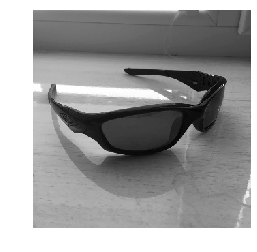

In [34]:
plot_img(img)

In [46]:
def check_and_visualize(img, kernel, padding=1):
    """Check the correctness of our conv_2d implementation"""
    
    s = time.time()
    expected = convolve(img, kernel, mode='constant')
    e = time.time()
    
    print(f'scipy: {e-s:.4f} seconds')
    
    s = time.time()
    produced = conv_2d(img, kernel, padding=padding)[:, :, 0]
    e = time.time()
    
    print(f'ours:  {e-s:.4f} seconds')
        
    try:
        assert (expected == produced).all()    
    except AssertionError:
        print(f'Comparison failed: {produced.sum()} != {expected.sum()}')
        
    plot_img(produced)

scipy: 0.0012 seconds
ours:  0.1210 seconds


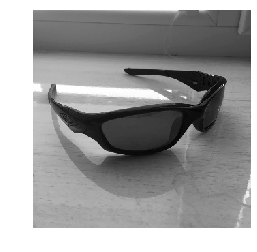

In [47]:
check_and_visualize(img, Kernel.IDENTITY)

scipy: 0.0017 seconds
ours:  0.1344 seconds


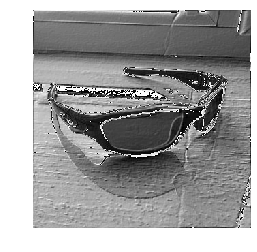

In [48]:
check_and_visualize(img, Kernel.EMBOSS)

scipy: 0.0023 seconds
ours:  0.1221 seconds


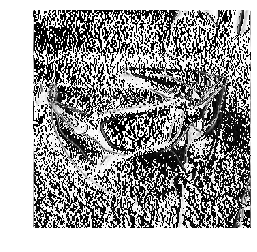

In [49]:
check_and_visualize(img, Kernel.GRAD_X)

scipy: 0.0078 seconds
ours:  0.1468 seconds


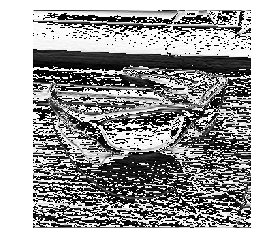

In [50]:
check_and_visualize(img, Kernel.GRAD_Y)

scipy: 0.0024 seconds
ours:  0.1295 seconds


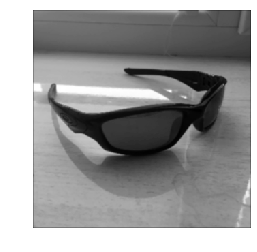

In [51]:
check_and_visualize(img, Kernel.GAUSSIAN_3X3)

scipy: 0.0052 seconds
ours:  0.1337 seconds


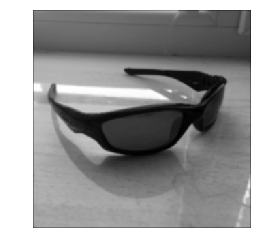

In [52]:
check_and_visualize(img, Kernel.GAUSSIAN_5X5, padding=2)

scipy: 0.0026 seconds
ours:  0.1313 seconds


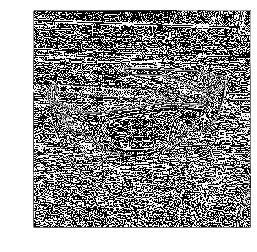

In [53]:
check_and_visualize(img, Kernel.LAPLACIAN)

scipy: 0.0023 seconds
ours:  0.1257 seconds


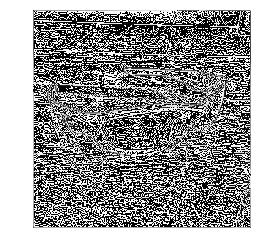

In [54]:
check_and_visualize(img, Kernel.NEGATIVE_LAPLACIAN)

scipy: 0.0225 seconds
ours:  0.3011 seconds


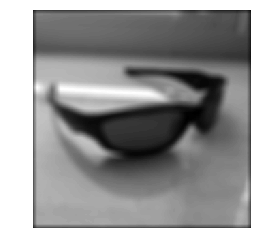

In [55]:
check_and_visualize(img, Kernel.gaussian(13, sigma=7), padding=6)

scipy: 0.0068 seconds
ours:  0.1455 seconds


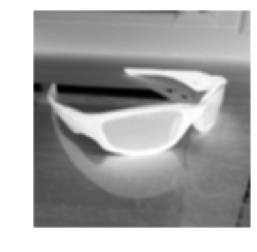

In [56]:
check_and_visualize(img, Kernel.dog(7, s1=11, s2=3), padding=3)